# Importing libraries

In [1]:
!pip install hmmlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.6/164.6 kB 5.6 MB/s eta 0:00:00


In [2]:
!pip install pykalman

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 6.1 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM
from pykalman import KalmanFilter
from scipy.optimize import minimize
from geopy.distance import geodesic
from scipy.optimize import minimize
from sklearn.metrics import mean_absolute_error, mean_squared_error
import statsmodels.api as sm

# Import and Preprocess data

In [4]:
data = pd.read_csv('/content/ts_epa_2020_west_sept_fill.csv')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29280 entries, 0 to 29279
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   station_id  29280 non-null  int64  
 1   datetime    29280 non-null  object 
 2   Longitude   29280 non-null  float64
 3   Latitude    29280 non-null  float64
 4   time_n      29280 non-null  int64  
 5   pm25        29280 non-null  float64
 6   temp        29280 non-null  float64
 7   wind        29280 non-null  float64
dtypes: float64(5), int64(2), object(1)
memory usage: 1.8+ MB


,station_id,datetime,Longitude,Latitude,time_n,pm25,temp,wind
0,41,2020-06-01T00:00:00Z,-121.247874,37.793392,1590969600,14.81,25.000000,13.485
1,41,2020-06-01T01:00:00Z,-121.247874,37.793392,1590973200,14.81,24.444444,14.285
2,41,2020-06-01T02:00:00Z,-121.247874,37.793392,1590976800,13.81,23.333333,14.445
3,41,2020-06-01T03:00:00Z,-121.247874,37.793392,1590980400,14.81,22.222222,14.965
4,41,2020-06-01T04:00:00Z,-121.247874,37.793392,1590984000,13.81,20.555556,15.535


In [5]:
station_96 = data[data['station_id'] == 96].copy()
station_96['datetime'] = pd.to_datetime(station_96['datetime'])

# Descriptive Statistics

In [ ]:
descr_stats = station_96[["pm25", 'temp', 'wind']]
descr_stats_summary = descr_stats.describe().T
descr_stats_summary["range"] = descr_stats_summary['max'] - descr_stats_summary['min']

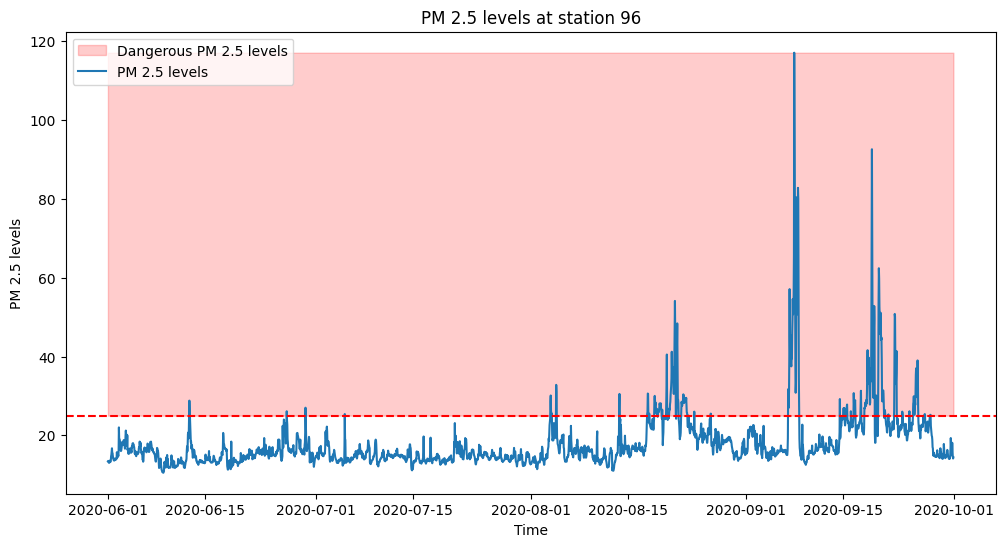

In [ ]:
plt.figure(figsize=(12,6))

plt.fill_between(
    station_96["datetime"],
    25,
    station_96["pm25"].max(),
    color='red',
    alpha=0.2,
    label = 'Dangerous PM 2.5 levels'
)

plt.plot(station_96["datetime"], station_96["pm25"], label='PM 2.5 levels')
plt.axhline(y=25, color="red", linestyle="--")
plt.legend()
plt.title('PM 2.5 levels at station 96')
plt.xlabel('Time')
plt.ylabel('PM 2.5 levels')
plt.show()

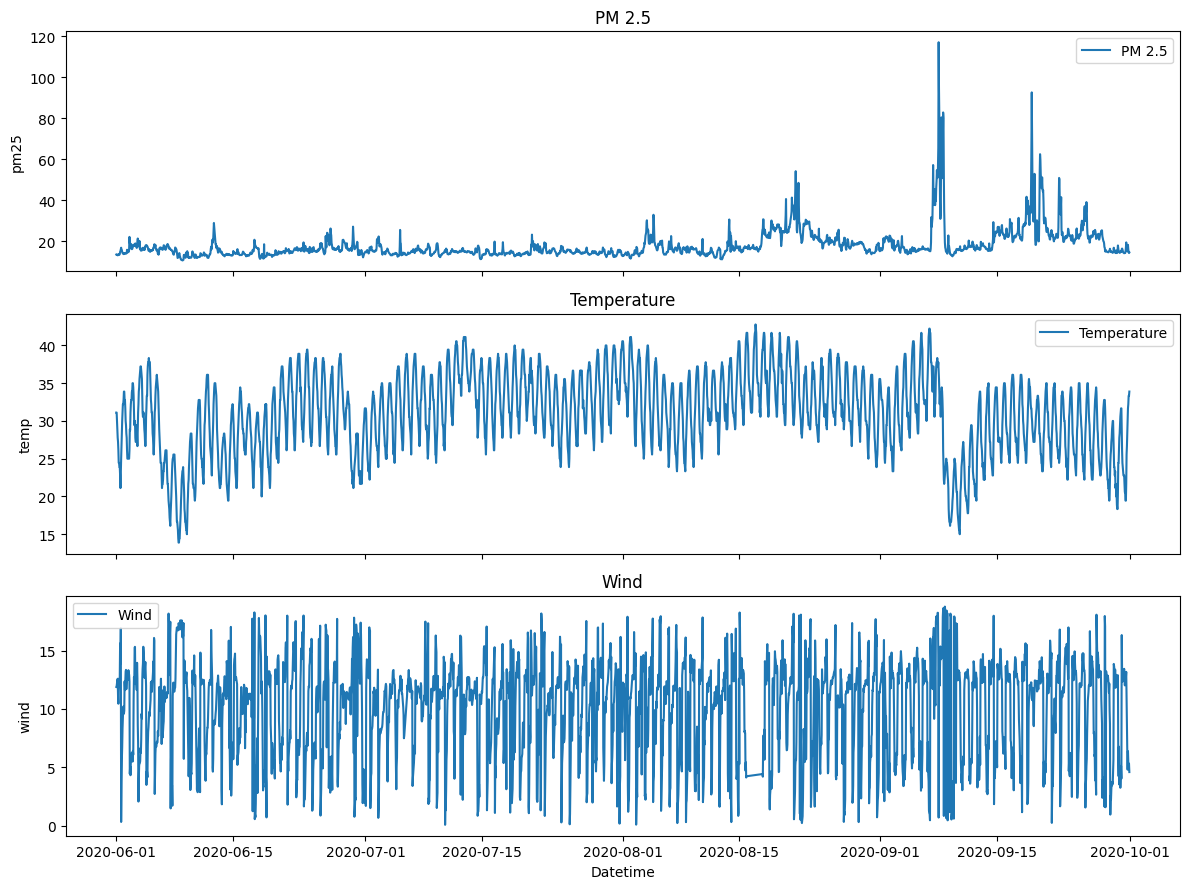

In [ ]:
# Daily observations

variables = ["pm25", "temp", "wind"]
labels_facet = {
  "pm25": "PM 2.5",
  "temp": "Temperature",
  "wind": "Wind"
  }

fig, axes = plt.subplots(3, 1, figsize=(12, 9), sharex=True)

for ax, var in zip(axes, variables):
  ax.plot(station_96["datetime"], station_96[var], label=labels_facet[var])
  ax.set_title(labels_facet[var])
  ax.set_ylabel(var)
  ax.legend()

axes[-1].set_xlabel("Datetime")

plt.tight_layout()

plt.show()

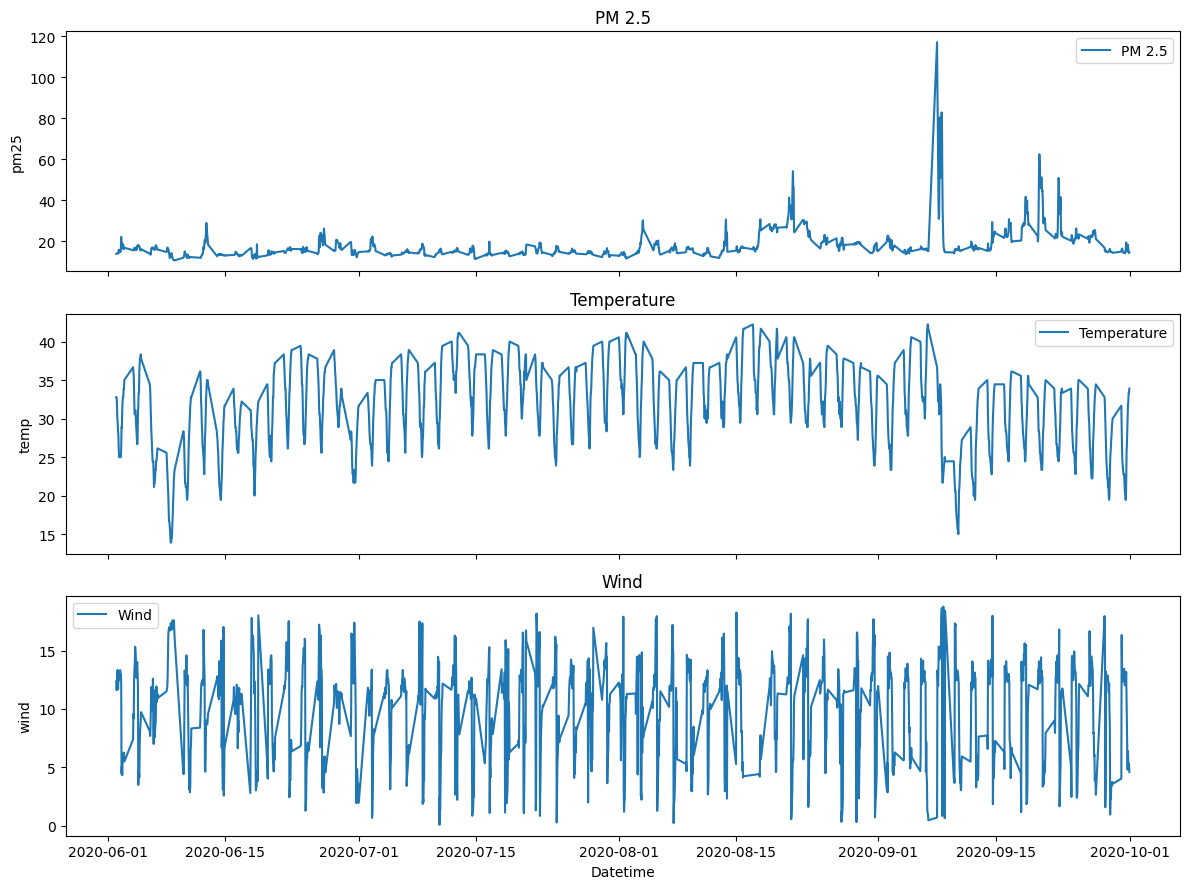

In [ ]:
# Observations every 2 days

station_96["date"] = station_96["datetime"].dt.date
station_96_filtered = station_96[station_96["date"].apply(lambda x: x.toordinal() % 2 == 0)]

variables = ["pm25", "temp", "wind"]
labels_facet = {
  "pm25": "PM 2.5",
  "temp": "Temperature",
  "wind": "Wind"
  }

fig, axes = plt.subplots(3, 1, figsize=(12, 9), sharex=True)

for ax, var in zip(axes, variables):
  ax.plot(station_96_filtered["datetime"], station_96_filtered[var], label=labels_facet[var])
  ax.set_title(labels_facet[var])
  ax.set_ylabel(var)
  ax.legend()

axes[-1].set_xlabel("Datetime")

plt.tight_layout()

plt.show()

# Hidden Markov Model

In [ ]:
model = GaussianHMM(n_components=3, random_state=29)
model.fit(station_96[['pm25']].values)
station_96['state'] = model.predict(station_96[['pm25']].values)

hmm_state_means = model.means_.flatten()
station_96["hmm_fitted"] = hmm_state_means[station_96["state"]]
hmm_state_variances = np.sqrt(model.covars_).flatten()
transition_matrix = model.transmat_
initial_prob = model.startprob_

print("Transition Matrix:\n", transition_matrix)
print("Initial Probabilities:\n", initial_prob)
print("State Means:\n", hmm_state_means)
print("State Standard Deviations:\n", hmm_state_variances)

Transition Matrix:
 [[9.82738404e-01 1.72615958e-02 3.31270185e-13]
 [4.38715763e-02 9.37979148e-01 1.81492759e-02]
 [2.32981987e-11 7.03162208e-02 9.29683779e-01]]
Initial Probabilities:
 [1.00000000e+00 9.27329315e-33 1.37824871e-51]
State Means:
 [14.71418202 20.89335066 37.91159597]
State Standard Deviations:
 [ 1.42686259  2.86434964 14.20574278]


# Random Walk plus noise

In [ ]:
def log_likelihood(params, data):
    """
    Computes the negative log-likelihood of the observations given the parameters.
    """
    transition_covariance, observation_covariance = params
    kf = KalmanFilter(
        transition_matrices=[1],
        observation_matrices=[1],
        initial_state_mean=data[0],
        initial_state_covariance=1,
        observation_covariance=observation_covariance,
        transition_covariance=transition_covariance
    )
    # Compute the log-likelihood
    loglikelihood = kf.loglikelihood(data)
    return -loglikelihood


observations = station_96["pm25"].values
result = minimize(
    fun=log_likelihood,
    x0=[1, 1],
    args=(observations,),
    bounds=[(1e-5, None), (1e-5, None)]
)


optimized_transition_covariance, optimized_observation_covariance = result.x

print("Estimated Variances:")
print(f"Transition Variance (Process Noise): {optimized_transition_covariance}")
print(f"Observation Variance (Observation Noise): {optimized_observation_covariance}")


KeyboardInterrupt: 

In [ ]:
kf = KalmanFilter(
    transition_matrices=[1],
    observation_matrices=[1],
    initial_state_mean=observations[0],
    initial_state_covariance=1,
    observation_covariance=optimized_observation_covariance,
    transition_covariance=optimized_transition_covariance
)

filtered_state_means, filtered_state_covariances = kf.filter(observations)
observation_means, smoothed_state_covariances = kf.smooth(observations)

In [ ]:
def calculate_error_metrics(observations, predictions):

  mae = mean_absolute_error(observations, predictions)
  msfe = mean_squared_error(observations, predictions)
  mape = np.mean(np.abs((observations - predictions)/observations)) * 100

  return {'MAE': mae, 'MSFE': msfe, 'MAPE': mape}


error_metrics = calculate_error_metrics(observations, observation_means)

print("Error Metrics:")
print(f"MAE: {error_metrics['MAE']:.4f}")
print(f"MAPE: {error_metrics['MAPE']:.2f}%")
print(f"MSFE: {error_metrics['MSFE']:.4f}")

Error Metrics:
MAE: 0.0000
MAPE: 30.97%
MSFE: 0.0000


In [ ]:
filtered_std_dev = np.sqrt(np.diagonal(filtered_state_covariances))
lower_bound = filtered_state_means - 1.96 * filtered_std_dev
upper_bound = filtered_state_means + 1.96 * filtered_std_dev

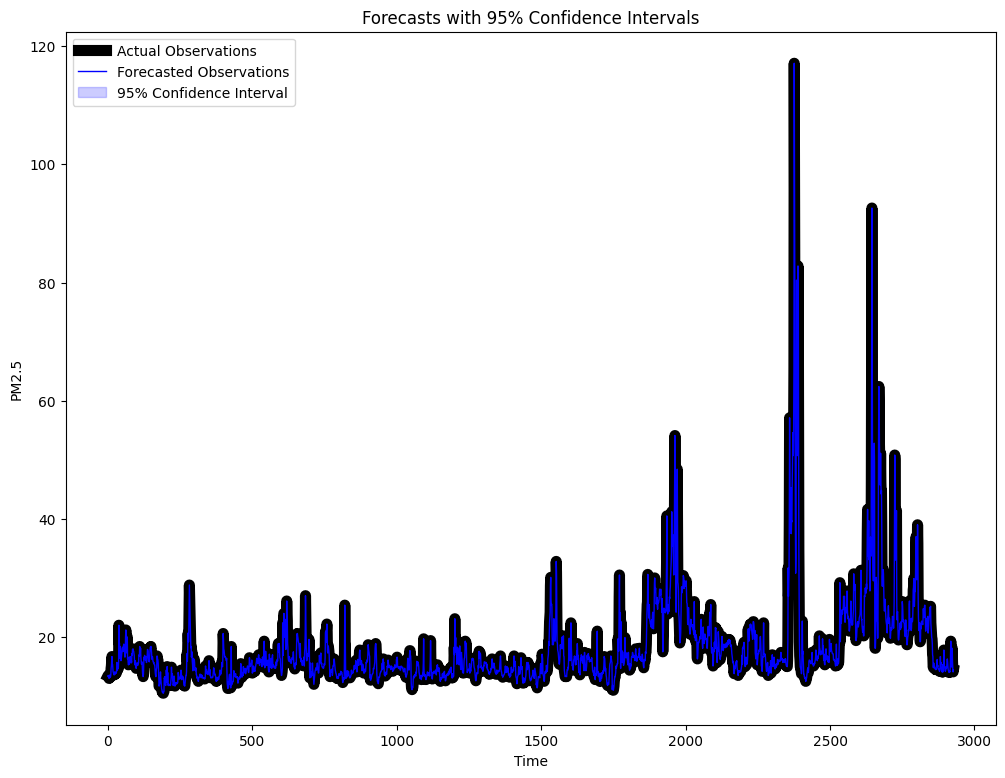

In [ ]:
plt.figure(figsize=(12, 9))
plt.plot(observations, label='Actual Observations', color='black', linewidth=8)
plt.plot(filtered_state_means, label='Forecasted Observations', color='blue', linewidth=1)
plt.fill_between(
    np.arange(len(observations)),
    lower_bound.flatten(),
    upper_bound.flatten(),
    color="blue",
    alpha=0.2,
    label="95% Confidence Interval",
)
plt.title("Forecasts with 95% Confidence Intervals")
plt.xlabel("Time")
plt.ylabel("PM2.5")
plt.legend()
plt.show()

# Dynamic Linear Model with regressive component

In [ ]:
observations = station_96["pm25"].values
regressor = station_96["wind"].values.reshape(-1, 1)

model = sm.tsa.SARIMAX(endog=observations, exog=regressor, order=(0, 0, 0), trend='n')
result = model.fit()

print(result.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2928
Model:                        SARIMAX   Log Likelihood              -10835.704
Date:                Sun, 22 Dec 2024   AIC                          21675.409
Time:                        17:48:30   BIC                          21687.373
Sample:                             0   HQIC                         21679.718
                               - 2928                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.5256      0.021     73.646      0.000       1.485       1.566
sigma2        95.9246      1.076     89.144      0.000      93.816      98.034
Ljung-Box (L1) (Q):                1886.66   Jarque-

In [ ]:
predicted = result.fittedvalues

mae = mean_absolute_error(observations, predicted)
mse = mean_squared_error(observations, predicted)
mape = np.mean(np.abs((observations - predicted) / observations)) * 100

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"MAPE: {mape:.2f}%")


MAE: 7.0135
MSE: 95.9244
MAPE: 37.77%


# Multivariate model

In [43]:
station_96['intercept'] = 1
out_var = station_96['pm25'].values
regressors = station_96[['intercept', 'wind', 'temp']].values

model = sm.tsa.SARIMAX(
    endog = out_var,
    exog = regressors,
    order = (0,0,0),
    trend='n',
    time_varying_regression = True,
    mle_regression = False
)

result = model.fit()

print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2928
Model:                        SARIMAX   Log Likelihood               -6815.529
Date:                Mon, 23 Dec 2024   AIC                          13639.058
Time:                        10:39:34   BIC                          13662.982
Sample:                             0   HQIC                         13647.674
                               - 2928                                         
Covariance Type:                  opg                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
var.const                 0.9724      0.056     17.324      0.000       0.862       1.082
var.x1                    0.0214      0.000     64.396      0.000       0.021       0.022
var.x2  

In [47]:
dynamic_coefficients

array([[21.12807947, -0.12565128, -0.20007971],
       [21.14572753, -0.12104042, -0.19892219],
       [21.08226417, -0.13769509, -0.20310242],
       ...,
       [14.03944944,  0.48188102, -0.05556288],
       [13.87922226,  0.46037542, -0.06662156],
       [14.05181203,  0.47782705, -0.05428971]])

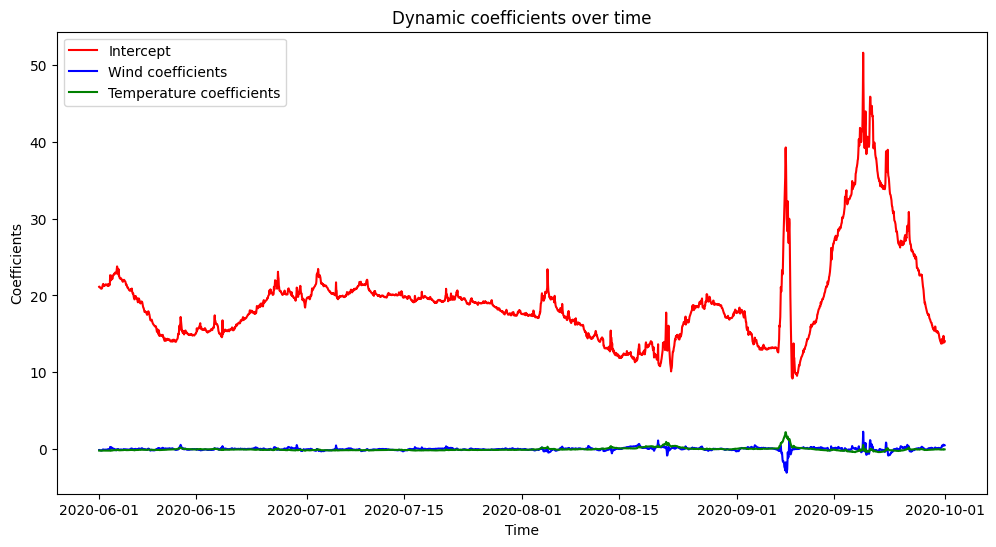

In [53]:
dynamic_coefficients = result.smoothed_state.T

plt.figure(figsize=(12, 6))
plt.plot(station_96['datetime'], dynamic_coefficients[:, 0], label = 'Intercept', color = 'red')
plt.plot(station_96['datetime'], dynamic_coefficients[:, 1], label = 'Wind coefficients', color = 'blue')
plt.plot(station_96['datetime'], dynamic_coefficients[:, 2], label = 'Temperature coefficients', color = 'green')
plt.title('Dynamic coefficients over time')
plt.xlabel('Time')
plt.ylabel('Coefficients')
plt.legend()
plt.show()